In [4]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import signal
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error


import os
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# Load data

In [5]:
files = [files for files in os.listdir("Part B/Raw data") if files.endswith('.csv')]
files = sorted(files)
columns = pd.read_csv(f'Part B/Raw data/{files[0]}').columns.tolist()

# Read all CSV files and concatenate them into a single DataFrame

rawdata = pd.DataFrame()
for file in files:
  data = pd.read_csv(f"Part B/Raw data/{file}")
  data.columns = columns
  rawdata = pd.concat([rawdata, data], ignore_index=True)

df = rawdata.copy()

# Create a datetime index from year, month, and day columns
df.set_index(pd.to_datetime(df[['Year', 'Month', 'Day']]), inplace=True)
df.sort_index(inplace=True)
df.head()



Station  Year  Month  Day  Daily Rainfall Total (mm)  \
1980-04-01  Changi  1980      4    1                        0.0   
1980-04-02  Changi  1980      4    2                       71.2   
1980-04-03  Changi  1980      4    3                        3.6   
1980-04-04  Changi  1980      4    4                        0.4   
1980-04-05  Changi  1980      4    5                        0.0   

           Highest 30 Min Rainfall (mm) Highest 60 Min Rainfall (mm)  \
1980-04-01                            —                            —   
1980-04-02                            —                            —   
1980-04-03                            —                            —   
1980-04-04                            —                            —   
1980-04-05                            —                            —   

           Highest 120 Min Rainfall (mm) Mean Temperature (°C)  \
1980-04-01                             —                     —   
1980-04-02                             —                     —   
1980-04-03                             —                     —   
1980-04-04                             —                     —   
1980-04-05                             —                     —   

           Maximum Temperature (°C) Minimum Temperature (°C)  \
1980-04-01                        —                        —   
1980-04-02                        —                        —   
1980-04-03                        —                        —   
1980-04-04                        —                        —   
1980-04-05                        —                        —   

           Mean Wind Speed (km/h) Max Wind Speed (km/h)  
1980-04-01                      —                     —  
1980-04-02                      —                     —  
1980-04-03                      —                     —  
1980-04-04                      —                     —  
1980-04-05                      —                     —

In [6]:
for col in df.columns:
  if col not in ["Station", "Year", "Month", "Day"]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Display the head and tail of the dataframe
display(df.head())

Station  Year  Month  Day  Daily Rainfall Total (mm)  \
1980-04-01  Changi  1980      4    1                        0.0   
1980-04-02  Changi  1980      4    2                       71.2   
1980-04-03  Changi  1980      4    3                        3.6   
1980-04-04  Changi  1980      4    4                        0.4   
1980-04-05  Changi  1980      4    5                        0.0   

            Highest 30 Min Rainfall (mm)  Highest 60 Min Rainfall (mm)  \
1980-04-01                           NaN                           NaN   
1980-04-02                           NaN                           NaN   
1980-04-03                           NaN                           NaN   
1980-04-04                           NaN                           NaN   
1980-04-05                           NaN                           NaN   

            Highest 120 Min Rainfall (mm)  Mean Temperature (°C)  \
1980-04-01                            NaN                    NaN   
1980-04-02                            NaN                    NaN   
1980-04-03                            NaN                    NaN   
1980-04-04                            NaN                    NaN   
1980-04-05                            NaN                    NaN   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
1980-04-01                       NaN                       NaN   
1980-04-02                       NaN                       NaN   
1980-04-03                       NaN                       NaN   
1980-04-04                       NaN                       NaN   
1980-04-05                       NaN                       NaN   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
1980-04-01                     NaN                    NaN  
1980-04-02                     NaN                    NaN  
1980-04-03                     NaN                    NaN  
1980-04-04                     NaN                    NaN  
1980-04-05                     NaN                    NaN

# Clean data

In [7]:
# check null 
print(df.isnull().sum())

Station                              0
Year                                 0
Month                                0
Day                                  0
Daily Rainfall Total (mm)            0
Highest 30 Min Rainfall (mm)     10444
Highest 60 Min Rainfall (mm)     10445
Highest 120 Min Rainfall (mm)    10445
Mean Temperature (°C)              547
Maximum Temperature (°C)           547
Minimum Temperature (°C)           547
Mean Wind Speed (km/h)             679
Max Wind Speed (km/h)              685
dtype: int64


In [8]:
cleanDf = df.drop(columns = ['Year', 'Month', 'Day']) 
cleanDf = cleanDf.drop(columns = ["Highest 30 Min Rainfall (mm)", "Highest 60 Min Rainfall (mm)", "Highest 120 Min Rainfall (mm)"]) # drop columns with high null values
cleanDf.head()

Station  Daily Rainfall Total (mm)  Mean Temperature (°C)  \
1980-04-01  Changi                        0.0                    NaN   
1980-04-02  Changi                       71.2                    NaN   
1980-04-03  Changi                        3.6                    NaN   
1980-04-04  Changi                        0.4                    NaN   
1980-04-05  Changi                        0.0                    NaN   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
1980-04-01                       NaN                       NaN   
1980-04-02                       NaN                       NaN   
1980-04-03                       NaN                       NaN   
1980-04-04                       NaN                       NaN   
1980-04-05                       NaN                       NaN   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
1980-04-01                     NaN                    NaN  
1980-04-02                     NaN                    NaN  
1980-04-03                     NaN                    NaN  
1980-04-04                     NaN                    NaN  
1980-04-05                     NaN                    NaN

In [9]:
## remove the data before Mean Wind Speed (km/h) is collected
# assign the cleaned data to clean_df
first_non_null_wind_speed = cleanDf['Mean Wind Speed (km/h)'].first_valid_index()
print(f"First non-null value of Mean Wind Speed (km/h): {first_non_null_wind_speed}")
print(f"Value: {cleanDf['Mean Wind Speed (km/h)'][first_non_null_wind_speed]}")
cleanDf = cleanDf[first_non_null_wind_speed:]
display(cleanDf.head())

print("check null values in cleaned dataframe:")
print(cleanDf.isnull().sum())
display(cleanDf[cleanDf.isnull().any(axis=1)])


First non-null value of Mean Wind Speed (km/h): 1983-01-01 00:00:00
Value: 5.5


Station  Daily Rainfall Total (mm)  Mean Temperature (°C)  \
1983-01-01  Changi                        0.3                   26.5   
1983-01-02  Changi                        0.4                   26.8   
1983-01-03  Changi                        2.9                   27.0   
1983-01-04  Changi                        0.0                   27.3   
1983-01-05  Changi                        0.0                   27.1   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
1983-01-01                      28.7                      25.1   
1983-01-02                      30.6                      24.8   
1983-01-03                      31.3                      24.5   
1983-01-04                      30.8                      25.0   
1983-01-05                      31.8                      23.7   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
1983-01-01                     5.5                   29.9  
1983-01-02                     9.4                   43.2  
1983-01-03                    10.7                   42.8  
1983-01-04                    12.6                   42.1  
1983-01-05                    10.3                   34.6

check null values in cleaned dataframe:
Station                       0
Daily Rainfall Total (mm)     0
Mean Temperature (°C)         0
Maximum Temperature (°C)      0
Minimum Temperature (°C)      0
Mean Wind Speed (km/h)       10
Max Wind Speed (km/h)        16
dtype: int64


Station  Daily Rainfall Total (mm)  Mean Temperature (°C)  \
2010-07-30  Changi                       24.4                   25.6   
2010-07-31  Changi                       36.3                   27.9   
2010-08-02  Changi                        0.0                   28.2   
2010-08-03  Changi                        0.0                   28.3   
2015-02-10  Changi                        0.0                   26.7   
2015-02-11  Changi                        0.0                   26.6   
2015-02-12  Changi                        0.0                   26.3   
2015-02-13  Changi                        0.0                   26.6   
2016-09-21  Changi                        2.5                   28.1   
2020-04-01  Changi                        0.0                   29.3   
2020-04-13  Changi                        0.0                   29.5   
2020-06-12  Changi                        0.0                   29.1   
2020-07-30  Changi                        0.6                   28.2   
2020-12-02  Changi                        4.6                   27.6   
2020-12-05  Changi                        0.0                   26.8   
2020-12-08  Changi                        0.0                   28.0   
2021-01-12  Changi                       13.0                   25.7   
2022-10-30  Changi                       38.8                   27.4   

            Maximum Temperature (°C)  Minimum Temperature (°C)  \
2010-07-30                      28.5                      22.8   
2010-07-31                      31.2                      24.4   
2010-08-02                      31.8                      25.6   
2010-08-03                      31.7                      24.6   
2015-02-10                      30.4                      24.5   
2015-02-11                      31.1                      23.6   
2015-02-12                      30.8                      23.3   
2015-02-13                      30.8                      24.0   
2016-09-21                      33.6                      24.0   
2020-04-01                      32.7                      26.4   
2020-04-13                      33.7                      27.1   
2020-06-12                      31.6                      27.2   
2020-07-30                      31.6                      25.3   
2020-12-02                      31.6                      24.3   
2020-12-05                      31.2                      25.4   
2020-12-08                      32.6                      25.6   
2021-01-12                      28.9                      23.9   
2022-10-30                      31.3                      23.2   

            Mean Wind Speed (km/h)  Max Wind Speed (km/h)  
2010-07-30                     NaN                    NaN  
2010-07-31                     NaN                    NaN  
2010-08-02                     NaN                    NaN  
2010-08-03                     NaN                    NaN  
2015-02-10                     NaN                    NaN  
2015-02-11                     NaN                    NaN  
2015-02-12                     NaN                    NaN  
2015-02-13                    10.4                    NaN  
2016-09-21                     NaN                    NaN  
2020-04-01                     9.9                    NaN  
2020-04-13                     8.4                    NaN  
2020-06-12                     NaN                   25.9  
2020-07-30                     7.9                    NaN  
2020-12-02                     4.8                    NaN  
2020-12-05                    18.8                    NaN  
2020-12-08                    16.9                    NaN  
2021-01-12                    14.1                    NaN  
2022-10-30                     NaN                   37.8

In [10]:
cleanDf.resample('D').max().isnull().sum()

Station                      2347
Daily Rainfall Total (mm)    2347
Mean Temperature (°C)        2347
Maximum Temperature (°C)     2347
Minimum Temperature (°C)     2347
Mean Wind Speed (km/h)       2357
Max Wind Speed (km/h)        2363
dtype: int64

There is about 2347 days without data collected. 

In [11]:
cleanDf = cleanDf.resample('D').max()
print("Null values after resampling to daily frequency:")
print(cleanDf.isnull().sum())
cleanDf_ffill = cleanDf.ffill() # forward fill the null values 
print("\nNull values after forward fill:")
print(cleanDf_ffill.isnull().sum())

Null values after resampling to daily frequency:
Station                      2347
Daily Rainfall Total (mm)    2347
Mean Temperature (°C)        2347
Maximum Temperature (°C)     2347
Minimum Temperature (°C)     2347
Mean Wind Speed (km/h)       2357
Max Wind Speed (km/h)        2363
dtype: int64

Null values after forward fill:
Station                      0
Daily Rainfall Total (mm)    0
Mean Temperature (°C)        0
Maximum Temperature (°C)     0
Minimum Temperature (°C)     0
Mean Wind Speed (km/h)       0
Max Wind Speed (km/h)        0
dtype: int64


# EDA

In [12]:
from plotly.subplots import make_subplots

import plotly.graph_objs as go

plot_data = cleanDf[['Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)', "Max Wind Speed (km/h)"]].reset_index()

fig = make_subplots(rows=4, cols=1, 
                    # shared_xaxes=True, 
                    subplot_titles=["Daily Rainfall Total (mm)", "Mean Temperature (°C)", "Mean Wind Speed (km/h)", "Max Wind Speed (km/h)"])

fig.add_trace(go.Scatter(x = plot_data["index"], y=plot_data["Daily Rainfall Total (mm)"]), row=1, col=1)
fig.add_trace(go.Scatter(x = plot_data["index"], y=plot_data["Mean Temperature (°C)"]), row=2, col=1)
fig.add_trace(go.Scatter(x = plot_data["index"], y=plot_data["Mean Wind Speed (km/h)"], line=dict(color='black')), row=3, col=1)
fig.add_trace(go.Scatter(x = plot_data["index"], y=plot_data["Max Wind Speed (km/h)"]), row=4, col=1)

fig.update_layout(height=900, width=1000, title_text="Daily Weather Data in Singapore", showlegend=False)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value")

fig.show()


## Resample to weekly and monthly

In [13]:
# resample on data without forward fill, for use in Prophet
meanDfWeekly = cleanDf[['Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']].resample('W').mean()
meanDfMonthly = cleanDf[['Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']].resample('ME').mean()
maxDfWeekly = cleanDf[["Maximum Temperature (°C)", "Max Wind Speed (km/h)"]].resample('W').max()
maxDfMonthly = cleanDf[["Maximum Temperature (°C)", "Max Wind Speed (km/h)"]].resample('ME').max()
print("Weekly:")
display(meanDfWeekly.head())
print("Monthly:")
display(meanDfMonthly.head())


Weekly:


Daily Rainfall Total (mm)  Mean Temperature (°C)  \
1983-01-02                   0.350000              26.650000   
1983-01-09                   3.600000              27.000000   
1983-01-16                  14.385714              26.228571   
1983-01-23                  12.542857              26.314286   
1983-01-30                   4.514286              26.071429   

            Mean Wind Speed (km/h)  
1983-01-02                7.450000  
1983-01-09               10.628571  
1983-01-16               10.500000  
1983-01-23               12.142857  
1983-01-30               12.800000

Monthly:


Daily Rainfall Total (mm)  Mean Temperature (°C)  \
1983-01-31                   7.935484              26.451613   
1983-02-28                   0.200000              28.060714   
1983-03-31                   0.600000              28.890323   
1983-04-30                   1.120000              29.376667   
1983-05-31                   1.083871              28.264516   

            Mean Wind Speed (km/h)  
1983-01-31               11.235484  
1983-02-28               13.696429  
1983-03-31               11.800000  
1983-04-30                9.213333  
1983-05-31                4.887097

In [14]:
# resample on data with forward fill, will be used for Model other than Prophet
meanDf_ffill_Weekly = cleanDf_ffill[['Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']].resample('W').mean()
meanDf_ffill_Monthly = cleanDf_ffill[['Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']].resample('ME').mean()
maxDf_ffill_Weekly = cleanDf_ffill[["Maximum Temperature (°C)", "Max Wind Speed (km/h)"]].resample('W').max()
maxDf_ffill_Monthly = cleanDf_ffill[["Maximum Temperature (°C)", "Max Wind Speed (km/h)"]].resample('ME').max()


In [15]:

print("Weekly Max")
display(maxDfWeekly.head())
print("Monthly Max")
display(maxDfMonthly.head())


Weekly Max


Maximum Temperature (°C)  Max Wind Speed (km/h)
1983-01-02                      30.6                   43.2
1983-01-09                      32.1                   42.8
1983-01-16                      31.3                   54.0
1983-01-23                      31.2                   59.8
1983-01-30                      31.6                   58.0

Monthly Max


Maximum Temperature (°C)  Max Wind Speed (km/h)
1983-01-31                      32.1                   59.8
1983-02-28                      34.6                   48.6
1983-03-31                      35.8                   52.2
1983-04-30                      35.8                   58.0
1983-05-31                      34.0                   55.8

In [16]:
# Monthly data with forward fill
# Prepare data for plotting
plot_data_monthly = meanDf_ffill_Monthly[['Daily Rainfall Total (mm)', 'Mean Temperature (°C)', 'Mean Wind Speed (km/h)']].reset_index()
plot_data_max_monthly = maxDf_ffill_Monthly[['Max Wind Speed (km/h)']].reset_index()

# Create individual plots
fig1 = px.line(plot_data_monthly, x='index', y='Daily Rainfall Total (mm)', 
               title='Mean Daily Rainfall Total (mm) in a monthly interval')
fig2 = px.line(plot_data_monthly, x='index', y='Mean Temperature (°C)', 
               title='Mean Temperature (°C) in monthly interval')
fig3 = px.line(plot_data_monthly, x='index', y='Mean Wind Speed (km/h)', 
               title='Mean Wind Speed (km/h) in monthly interval')
fig4 = px.line(plot_data_max_monthly, x='index', y='Max Wind Speed (km/h)',
                title='Max Wind Speed (km/h) in monthly interval')

# Show plots
fig1.show()
fig2.show()
fig3.show()
fig4.show()


# Time series modeling

In [17]:
# ADF Test for stationarity
from statsmodels.tsa.stattools import adfuller

def adf_test(series, name="Data"):
    result = adfuller(series.dropna())
    print(f"ADF Test for {name}:")
    print(f"  Test Statistic: {result[0]:.4f}")
    print(f"  P-value: {result[1]:.4f}")
    print(f"  Critical Values: {result[4]}")
    print("  Stationary" if result[1] < 0.05 else "  Not Stationary")
    print()



## Using Periodigram
to determine the power spectrum frequency components and remap the frequency axis to time period for better explainability

In [18]:
meanDf_ffill_Monthly.columns

Index(['Daily Rainfall Total (mm)', 'Mean Temperature (°C)',
       'Mean Wind Speed (km/h)'],
      dtype='object')

In [19]:
def plot_periodogram(data, column, fs = 12, xlimit = [0, 36], title= "Periodogram"):
  data_temp = data[[column]].dropna()
  # Detrend the data to remove long-term trends
  data_temp['detrended'] = signal.detrend(data_temp[column].to_numpy())
  freqs, power = signal.periodogram(data_temp['detrended'], fs=fs)

  # Convert frequencies to periods (in months), excluding freq=0
  periods = fs / freqs[1:]  # Skip the DC component (freq=0)
  power = power[1:]  # Corresponding power values
  fig = px.line(x=periods, y=power, markers=True,
                title=title)
  fig.update_layout(
      xaxis=dict(
          range=xlimit  # Sets the maximum x-axis to 36, lower bound is 0
      )
  )
  fig.update_xaxes(title_text="Period")
  fig.update_yaxes(title_text="Power Spectral Density")
  fig.show()

  # Identify the dominant period
  dominant_period = periods[np.argmax(power)]
  print(f"Dominant period: {dominant_period:.2f} months")


In [20]:
data = meanDf_ffill_Monthly
column = 'Daily Rainfall Total (mm)'
fs = 12
title = "Periodogram of Monthly Rainfall"
plot_periodogram(data, column, fs, xlimit=[0, 24], title= title )

data = meanDf_ffill_Monthly
column = 'Mean Temperature (°C)'
fs = 12
title = "Periodogram of Monthly Temperature"
plot_periodogram(data, column, fs, xlimit=[0, 24], title= title )

data = meanDf_ffill_Monthly
column = 'Mean Wind Speed (km/h)'
fs = 12
title = "Periodogram of Monthly Wind Speed (Singapore)"
plot_periodogram(data, column, fs, xlimit=[0, 24], title= title )

Dominant period: 12.02 months


Dominant period: 12.02 months


Dominant period: 6.01 months


In [21]:
data = meanDf_ffill_Weekly
column = 'Daily Rainfall Total (mm)'
fs = 52
title = "Periodogram of Weekly Rainfall"
plot_periodogram(data, column, fs, xlimit=[0, 104], title= title )

data = meanDf_ffill_Weekly
column = 'Mean Temperature (°C)'
fs = 52
title = "Periodogram of Weekly Temperature"
plot_periodogram(data, column, fs, xlimit=[0, 104], title= title )

data = meanDf_ffill_Weekly
column = 'Mean Wind Speed (km/h)'
fs = 52
title = "Periodogram of Weekly Wind Speed (Singapore)"
plot_periodogram(data, column, fs, xlimit=[0, 104], title= title )


Dominant period: 52.31 months


Dominant period: 52.31 months


Dominant period: 26.15 months


| Dominant period | Rainfall | Temperature | Wind | 
|-----------------|----------|-------------|------|
| meanDf_ffill_Monthly| 12 | 12 | 6 |  
| meanDf_ffill_Weekly | 52 | 52 | 26 |  



## Prophet

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Remove verbose logging
import logging
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").disabled=True


In [45]:
def plot_prophet_forecast(data, column, forecast_period, freq = "ME"):
  # Prepare the data for Prophet
  # Prophet requires the dataframe to have columns 'ds' (datestamp) and 'y' (value)
  # Using monthly mean temperature data
  prophet_df = data[:-forecast_period][[column]].reset_index()
  prophet_df = prophet_df.rename(columns={'index': 'ds', column: 'y'})
  # Drop rows with NaN values in 'y'
  prophet_df = prophet_df.dropna(subset=['y'])
  model = Prophet()
  model.fit(prophet_df)
  future = model.make_future_dataframe(periods=forecast_period, freq=freq)
  forecast = model.predict(future)
  predicted_values = forecast[['ds','yhat']][-forecast_period:]
  predicted_values["y"] = data[-forecast_period:][column].values
  predicted_values.dropna(inplace=True)
  mape_test = mean_absolute_percentage_error(predicted_values["y"], predicted_values["yhat"])
  print(f'Model Mean Absolute Percentage Error of {column} on testing data is {mape_test*100:.2f}%')
  rmse_test = root_mean_squared_error(predicted_values["y"], predicted_values["yhat"])
  print(f'Model Root Mean Squared Error of {column} on testing data is {rmse_test:.2f}')
  rmse_train = root_mean_squared_error(prophet_df['y'], model.predict(prophet_df)['yhat'])
  print(f'Model Root Mean Squared Error of {column} on training data is {rmse_train:.2f}')

  # plot the forecast
  fig = model.plot(forecast)
  ax = fig.gca()
  ax.scatter(predicted_values['ds'], predicted_values['y'], color='blue', label='observed', s=10)
  ax.set_title(f'{column} Forecast with Prophet')
  ax.set_xlabel('Date')
  ax.set_ylabel(column)
  xlimit = [forecast['ds'].max()-pd.DateOffset(months=36), forecast['ds'].max()]
  plt.xlim(xlimit)
  plt.show()

  # plot components
  fig = model.plot_components(forecast)
  plt.show()

  return


### Monthly

Model Mean Absolute Percentage Error of Daily Rainfall Total (mm) on testing data is 61.55%
Model Root Mean Squared Error of Daily Rainfall Total (mm) on testing data is 3.38
Model Root Mean Squared Error of Daily Rainfall Total (mm) on training data is 3.23


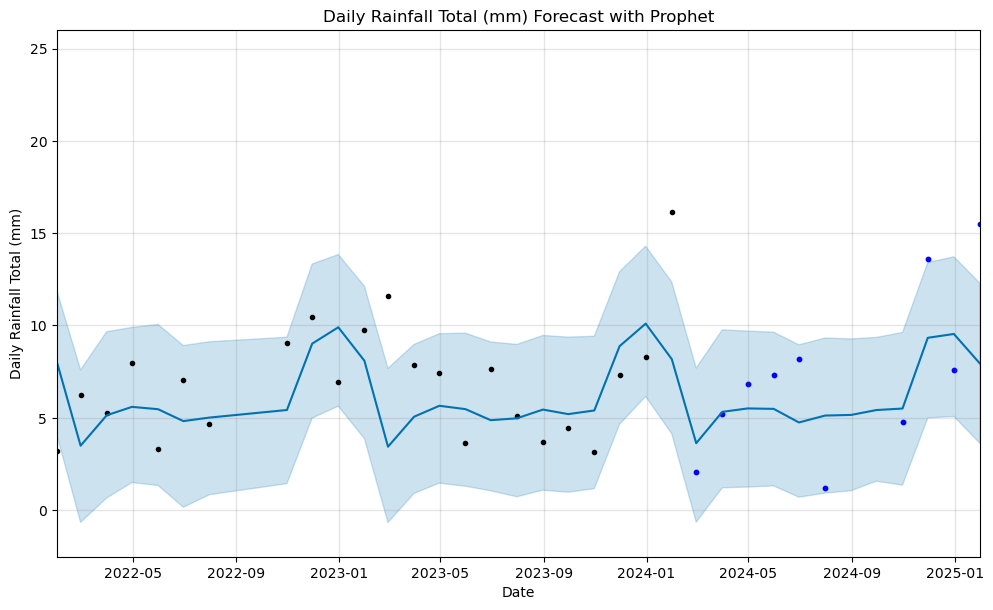

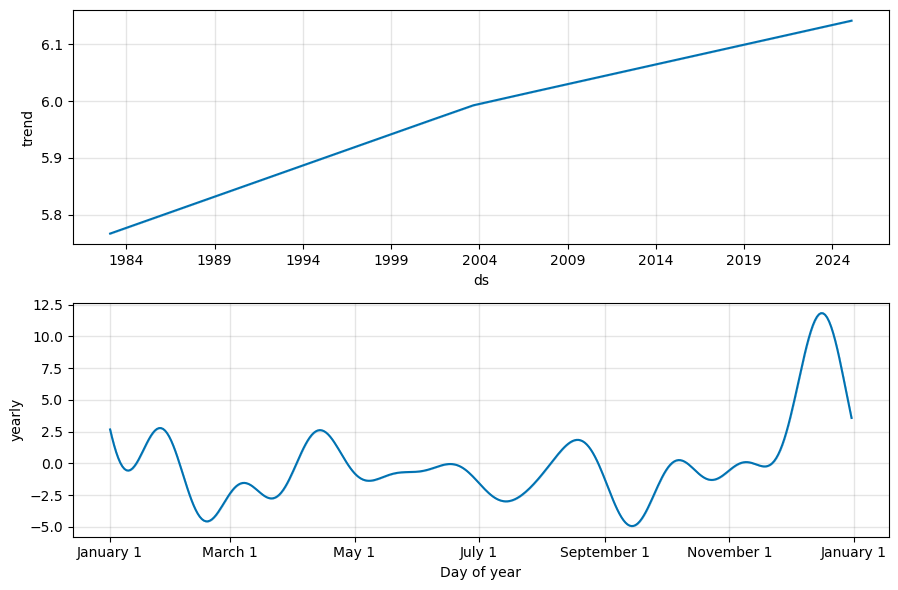

Model Mean Absolute Percentage Error of Mean Temperature (°C) on testing data is 1.56%
Model Root Mean Squared Error of Mean Temperature (°C) on testing data is 0.51
Model Root Mean Squared Error of Mean Temperature (°C) on training data is 0.45


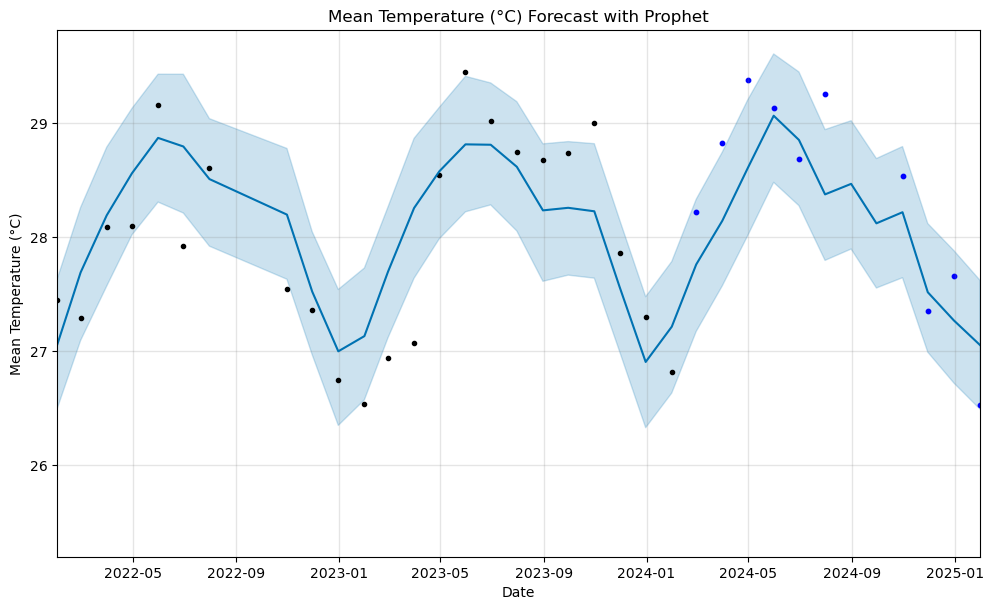

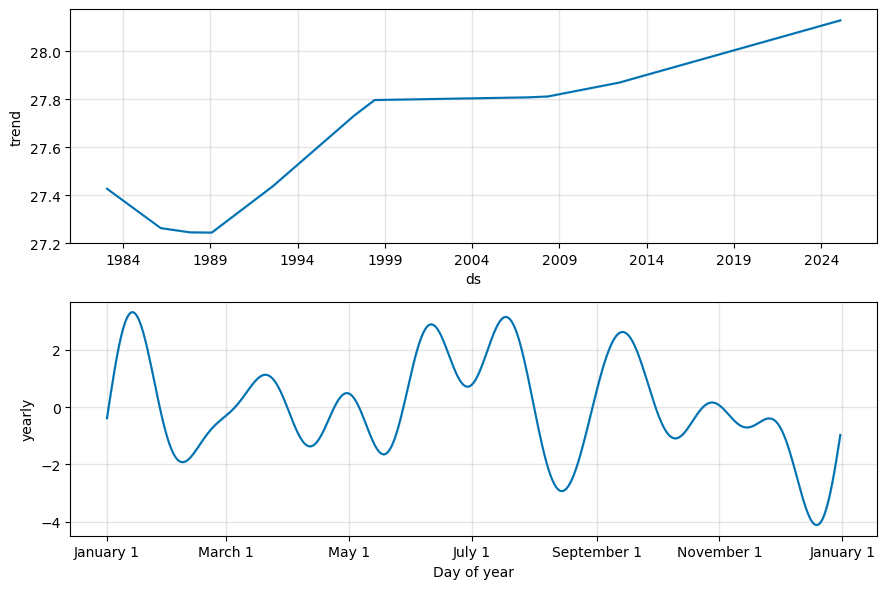

Model Mean Absolute Percentage Error of Mean Wind Speed (km/h) on testing data is 13.86%
Model Root Mean Squared Error of Mean Wind Speed (km/h) on testing data is 2.19
Model Root Mean Squared Error of Mean Wind Speed (km/h) on training data is 1.49


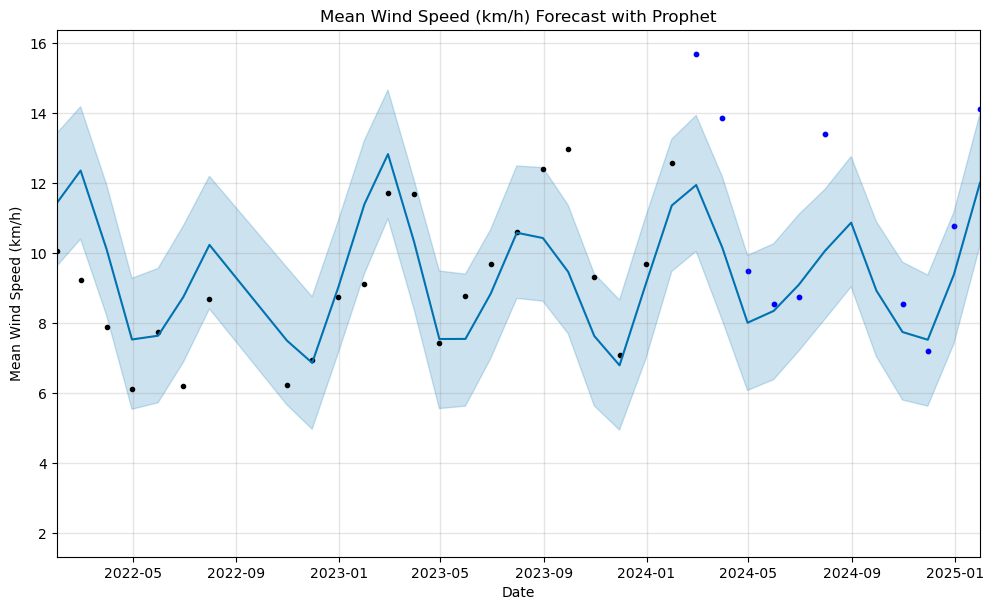

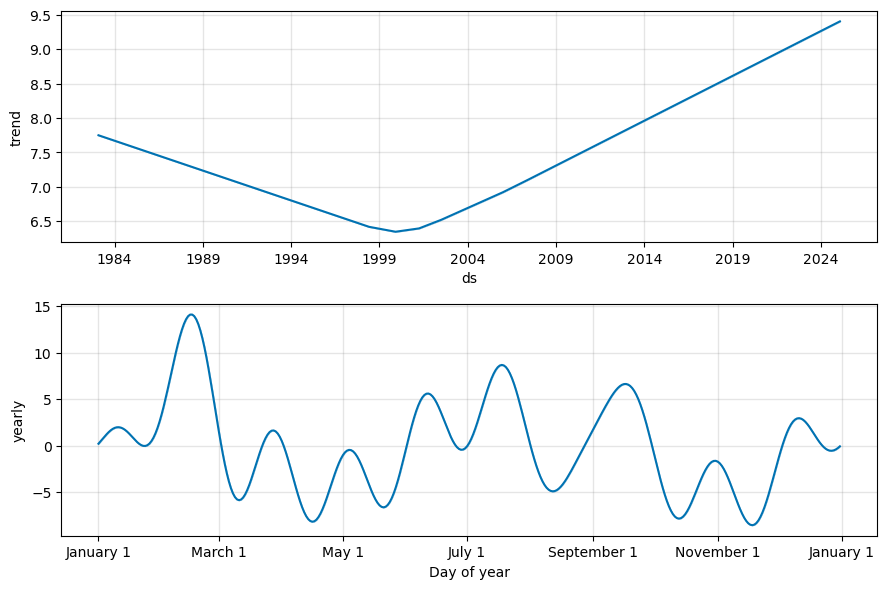

In [46]:
plot_prophet_forecast(meanDfMonthly, "Daily Rainfall Total (mm)", 12, freq = "ME")
plot_prophet_forecast(meanDfMonthly, "Mean Temperature (°C)", 12, freq = "ME")
plot_prophet_forecast(meanDfMonthly, "Mean Wind Speed (km/h)", 12, freq = "ME")


### Weekly

Model Mean Absolute Percentage Error of Daily Rainfall Total (mm) on testing data is 242814934824890144.00%
Model Root Mean Squared Error of Daily Rainfall Total (mm) on testing data is 7.91
Model Root Mean Squared Error of Daily Rainfall Total (mm) on training data is 6.72


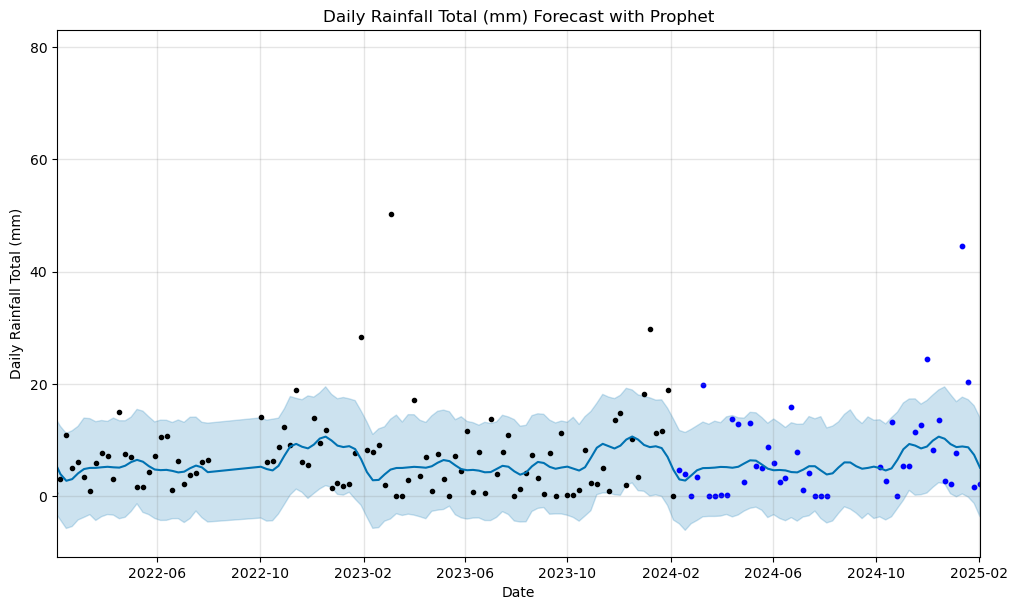

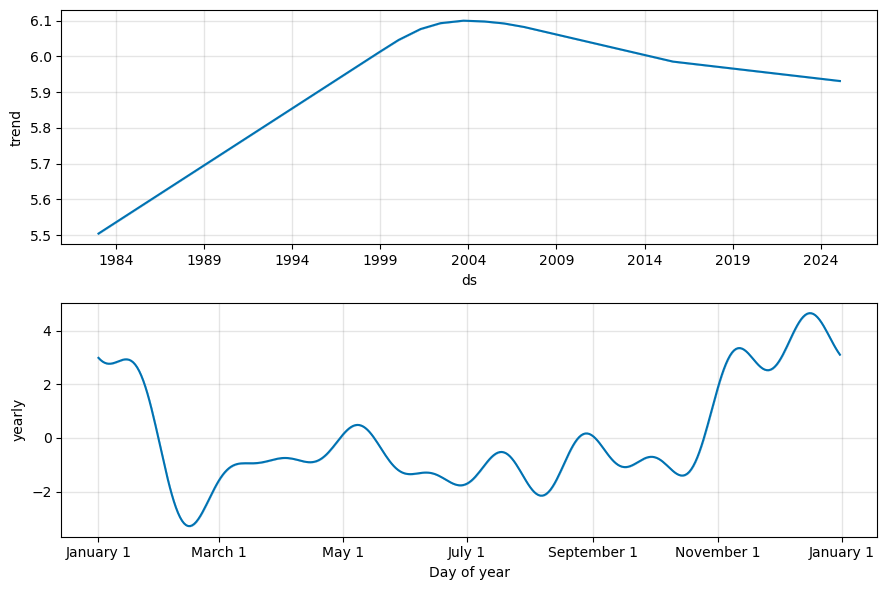

Model Mean Absolute Percentage Error of Mean Temperature (°C) on testing data is 2.24%
Model Root Mean Squared Error of Mean Temperature (°C) on testing data is 0.79
Model Root Mean Squared Error of Mean Temperature (°C) on training data is 0.66


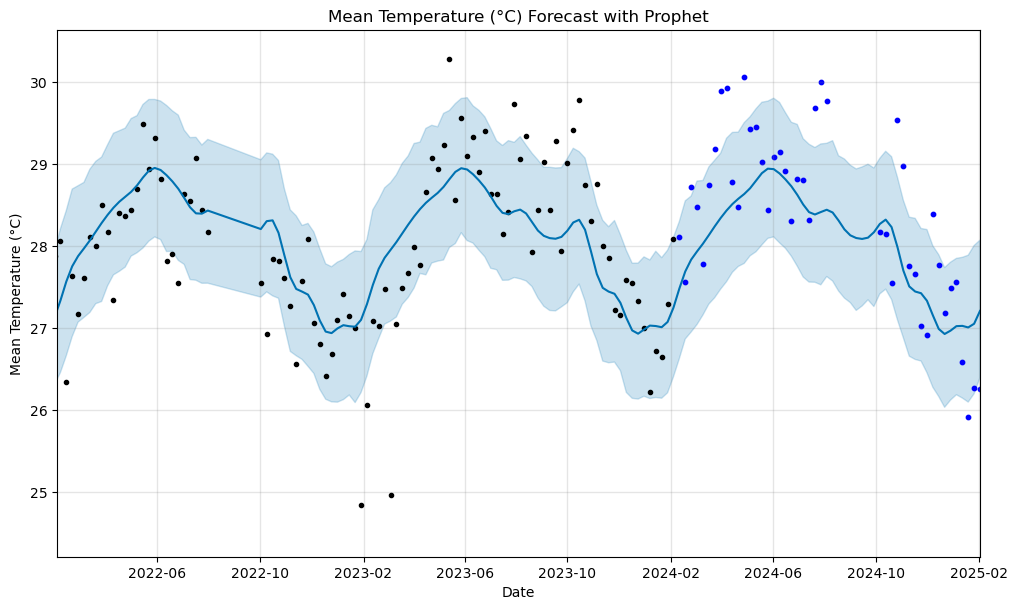

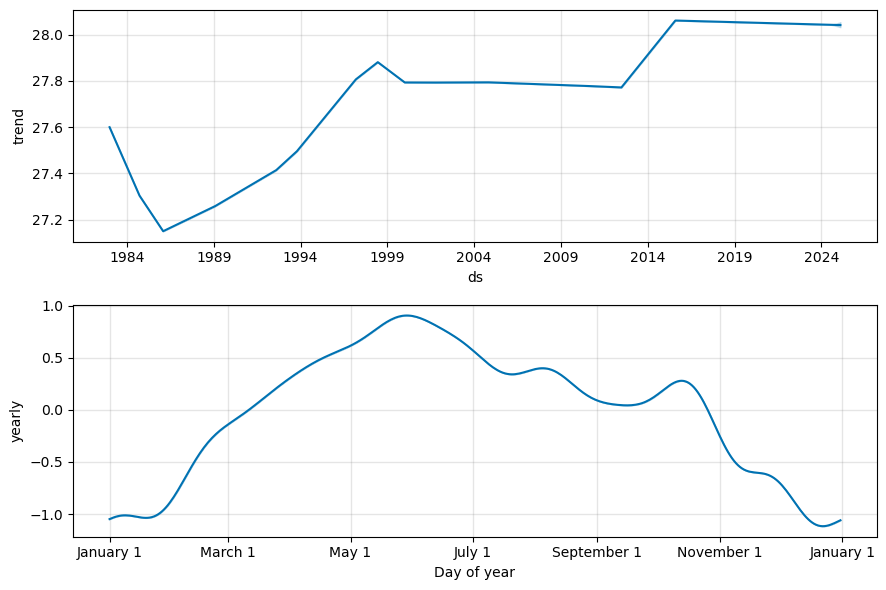

Model Mean Absolute Percentage Error of Mean Wind Speed (km/h) on testing data is 16.51%
Model Root Mean Squared Error of Mean Wind Speed (km/h) on testing data is 2.72
Model Root Mean Squared Error of Mean Wind Speed (km/h) on training data is 2.11


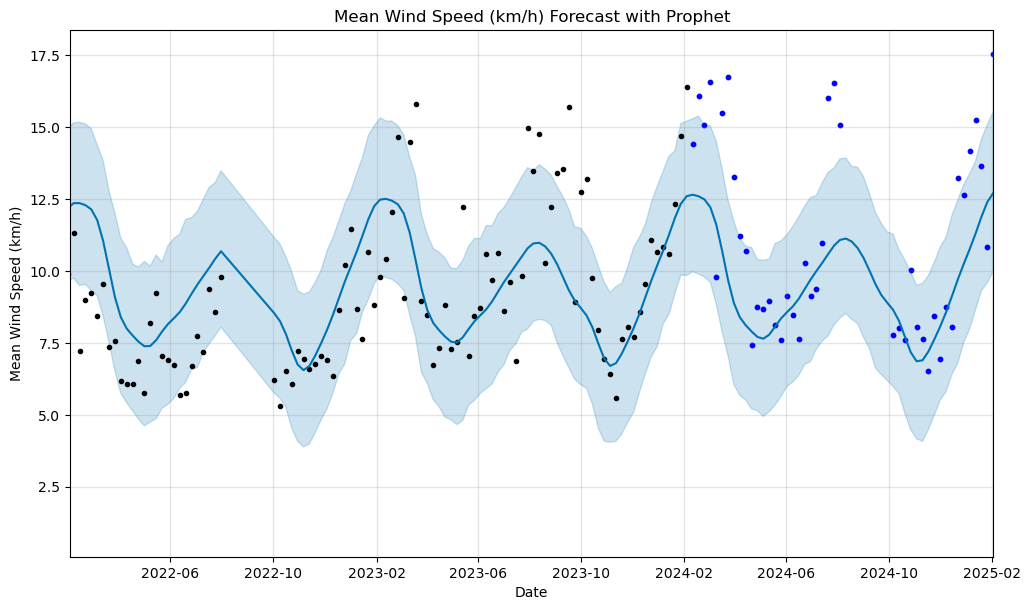

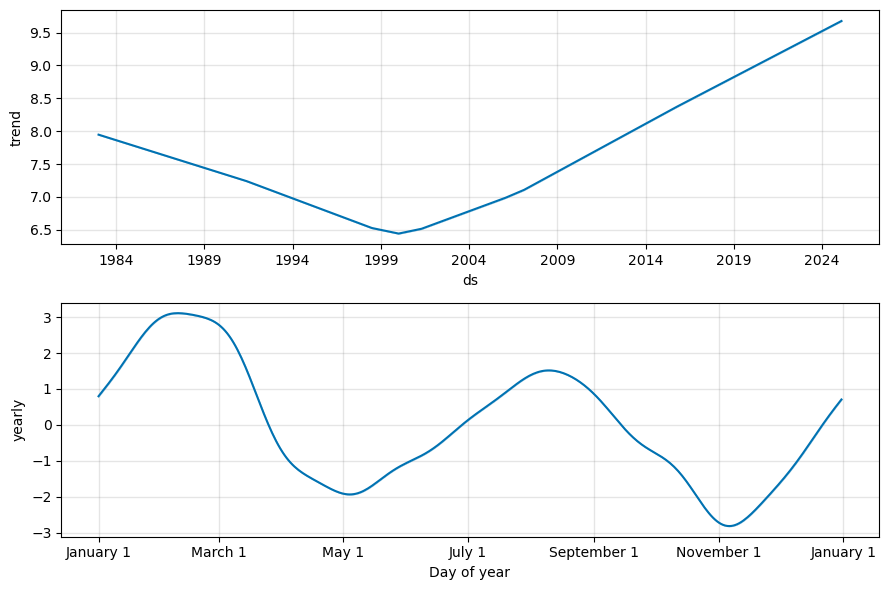

In [25]:
plot_prophet_forecast(meanDfWeekly, "Daily Rainfall Total (mm)", 52, freq = "W")
plot_prophet_forecast(meanDfWeekly, "Mean Temperature (°C)", 52, freq = "W")
plot_prophet_forecast(meanDfWeekly, "Mean Wind Speed (km/h)", 52, freq = "W")

Model Mean Absolute Percentage Error of Daily Rainfall Total (mm) on testing data is 121.74%
Model Root Mean Squared Error of Daily Rainfall Total (mm) on testing data is 12.40
Model Root Mean Squared Error of Daily Rainfall Total (mm) on training data is 6.70


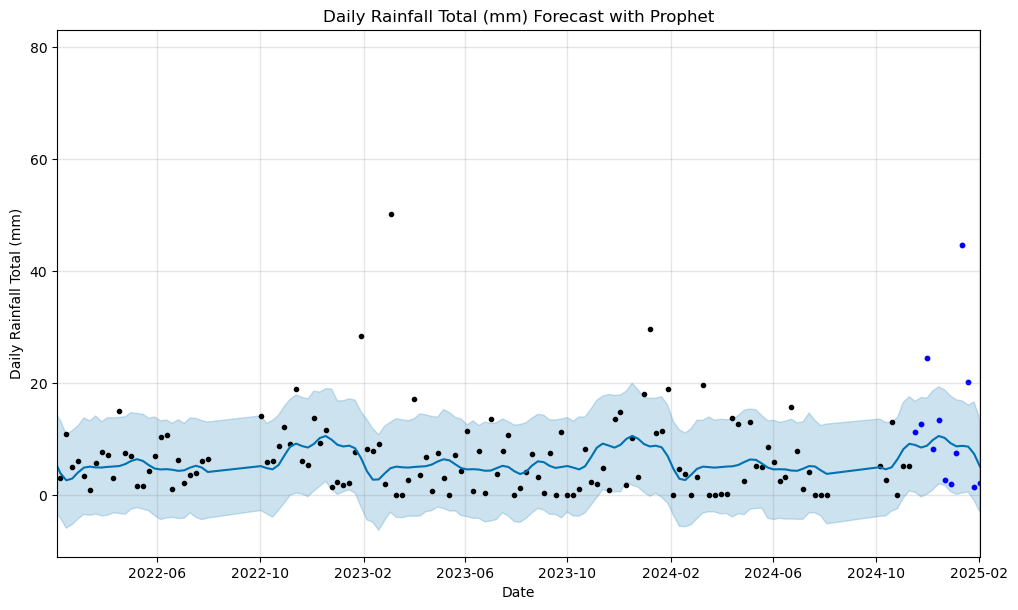

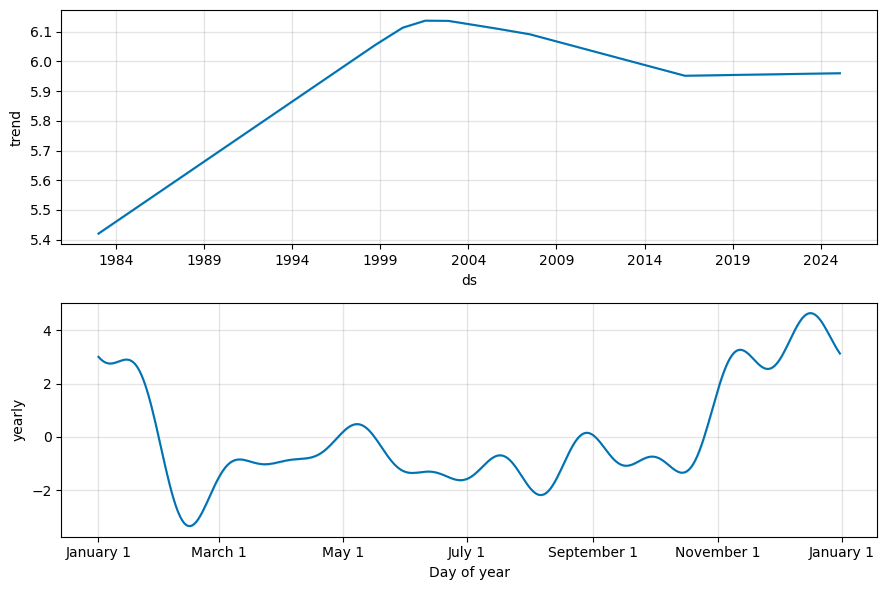

Model Mean Absolute Percentage Error of Mean Temperature (°C) on testing data is 2.35%
Model Root Mean Squared Error of Mean Temperature (°C) on testing data is 0.72
Model Root Mean Squared Error of Mean Temperature (°C) on training data is 0.67


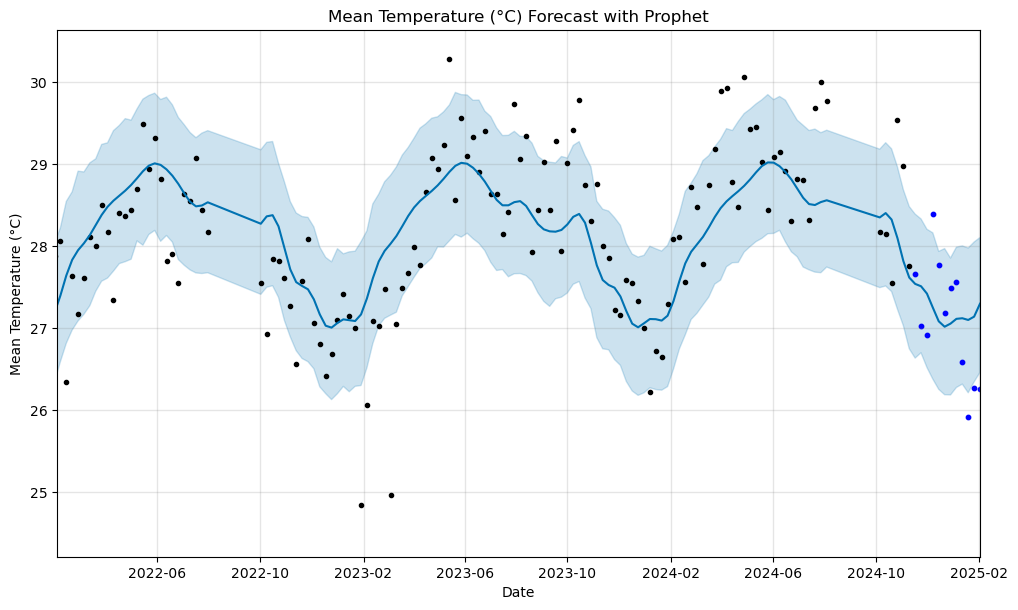

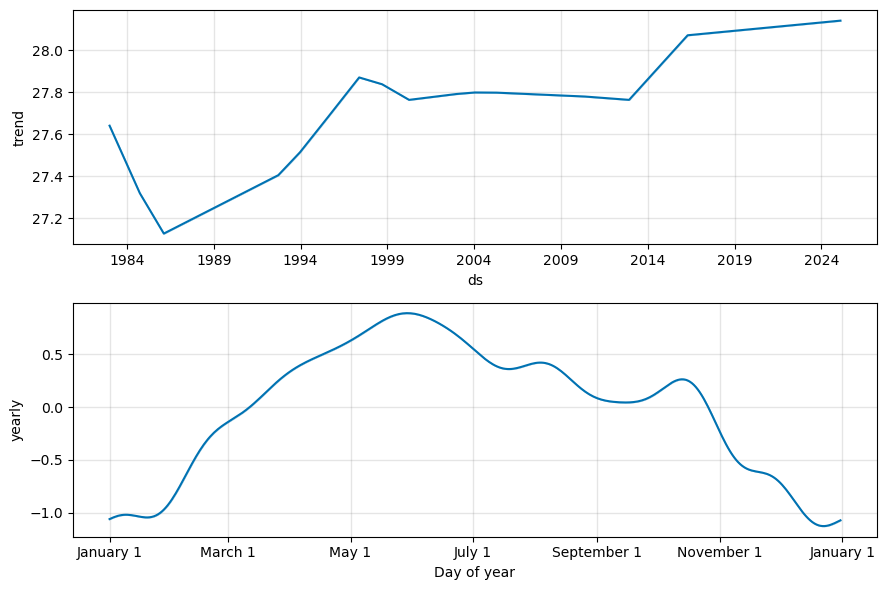

Model Mean Absolute Percentage Error of Mean Wind Speed (km/h) on testing data is 16.65%
Model Root Mean Squared Error of Mean Wind Speed (km/h) on testing data is 2.44
Model Root Mean Squared Error of Mean Wind Speed (km/h) on training data is 2.12


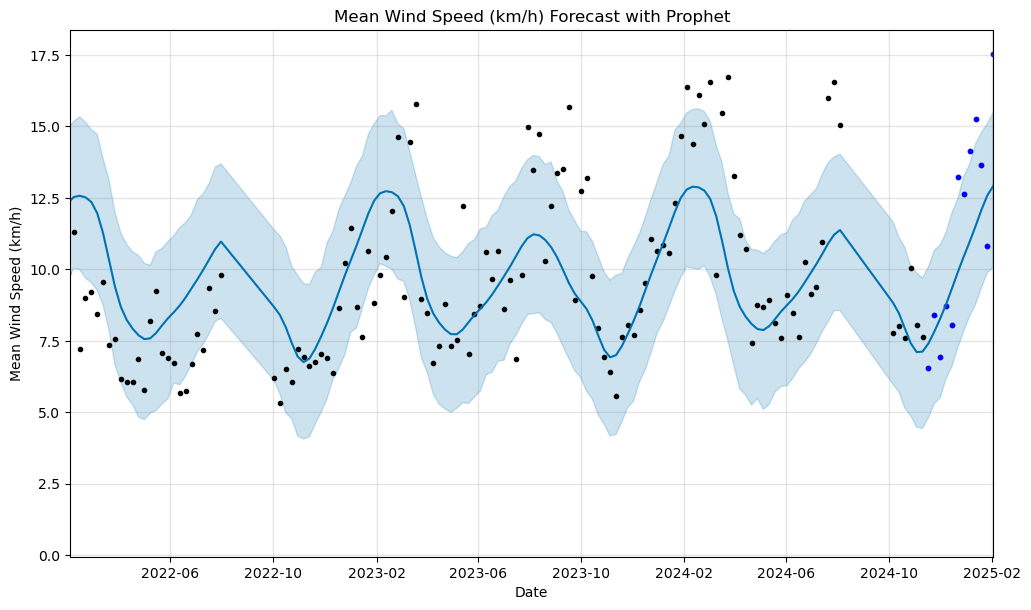

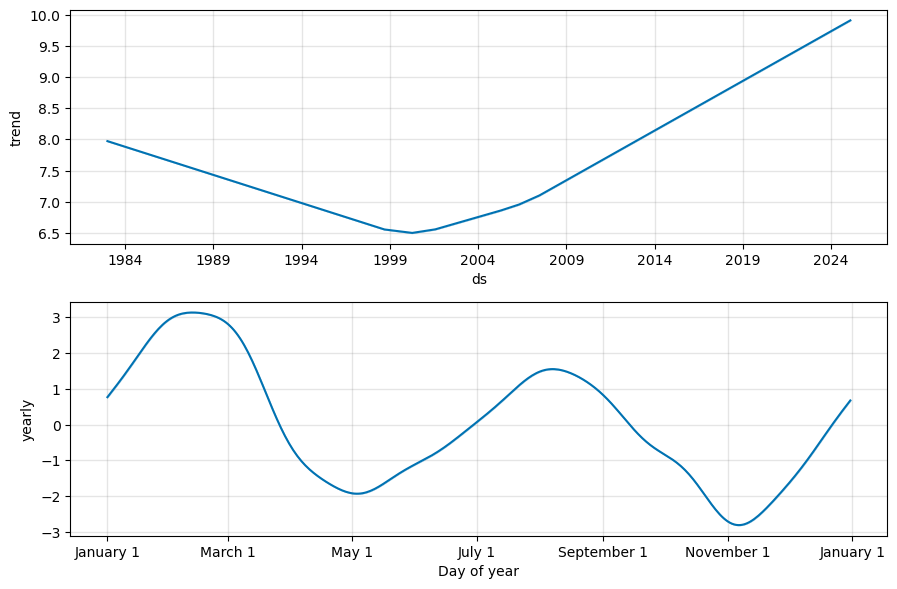

In [26]:
plot_prophet_forecast(meanDfWeekly, "Daily Rainfall Total (mm)", 12, freq = "W")
plot_prophet_forecast(meanDfWeekly, "Mean Temperature (°C)", 12, freq = "W")
plot_prophet_forecast(meanDfWeekly, "Mean Wind Speed (km/h)", 12, freq = "W")

### Summary of Prophet result
Mean Absolute Percent Error
|  |Rainfall | Temperature | Wind speed|
|--------------------------|----------------|-----------------|---------------|
| Monthly (12 month forecast) | 61.55% | 1.56% | 13.36% |
| Weekly (51 week forecast) | Super high error | 2.24% | 16.51% |
| Weekly (12 week forecast) | 121% | 2.35% | 16.65% |

Root Mean Square Error
|  |Rainfall | Temperature | Wind speed|
|--------------------------|----------------|-----------------|---------------|
| Monthly (12 month forecast) |3.38 | 0.51 | 2.19 |
| Weekly (51 week forecast) | 7.91 | 0.79 | 2.72 |
| Weekly (12 week forecast) | 12.40| 0.72 | 2.44 |

The longer into the future on the forecast the worst is the error.  
The monthy interval have bettere forecast result

The trend of the weather is getter wetter, hotter and windly based on the trend plot.

## Holt Winters Exponential Smoothing

In [69]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def holtwinter_exponential(data, column, seasonal_periods, forecast_period):
  holt_winters_model = ExponentialSmoothing(data[:-forecast_period][column], seasonal_periods=seasonal_periods, trend='add', seasonal='add')
  # Fit the model
  holt_winters_fit = holt_winters_model.fit()
  # Make forecast using Holt-Winters model
  holt_winters_forecast = holt_winters_fit.forecast(forecast_period) # Forecast for the next 12 month
  mape_test = mean_absolute_percentage_error(data[-forecast_period:][column], holt_winters_forecast)
  print(f'Mean Absolute Percentage Error of {column} on testing data is {mape_test*100:.2f}%')
  rmse_test = root_mean_squared_error(data[-forecast_period:][column], holt_winters_forecast)
  print(f'Mean Root Squared Error of {column} on testing data is {rmse_test:.2f}')
  rmse_train = root_mean_squared_error(data[:-forecast_period][column], holt_winters_fit.fittedvalues)
  print(f'Mean Root Squared Error of {column} on training data is {rmse_train:.2f}')

  # Plot the original data, fitted values, and the forecast from Holt-Winters model
  plt.figure(figsize=(14, 5))
  plt.plot(data.index, data[column], label='Original Data')
  plt.plot(holt_winters_fit.fittedvalues.index, holt_winters_fit.fittedvalues, label='Fitted Values', color='green')
  plt.plot(holt_winters_forecast.index, holt_winters_forecast, label='Forecast', color='red')
  plt.title(f'Holt-Winters Triple Exponential Smoothing Forecast\n {column}')
  plt.xlabel('Month')
  plt.ylabel(column)
  plt.xlim([data.index[-forecast_period*5], holt_winters_forecast.index.max()])
  plt.legend()
  plt.show()
  return


### Monthly

Mean Absolute Percentage Error of Daily Rainfall Total (mm) on testing data is 710289285368096256.00%
Mean Root Squared Error of Daily Rainfall Total (mm) on testing data is 6.08
Mean Root Squared Error of Daily Rainfall Total (mm) on training data is 6.43


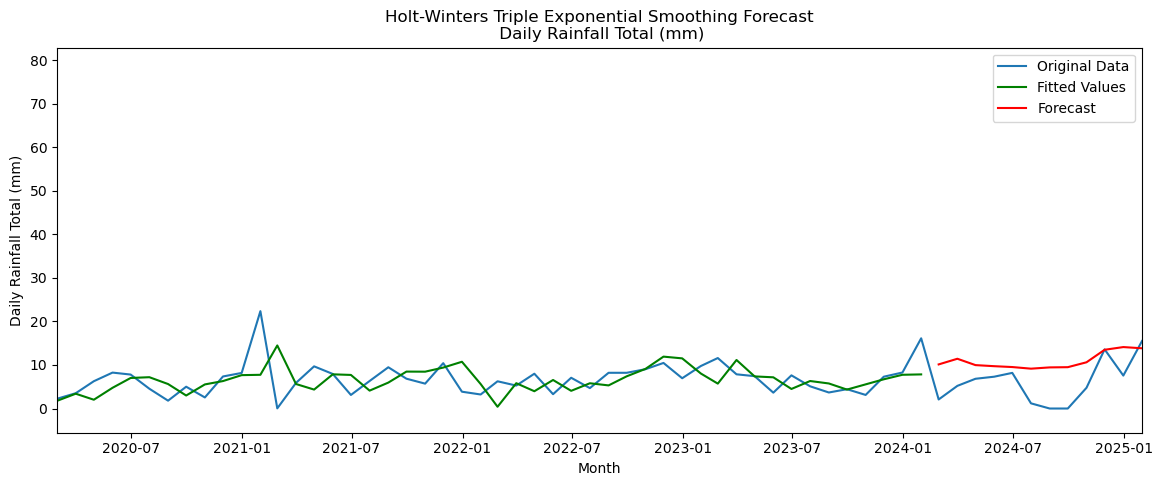

Mean Absolute Percentage Error of Mean Temperature (°C) on testing data is 2.03%
Mean Root Squared Error of Mean Temperature (°C) on testing data is 0.66
Mean Root Squared Error of Mean Temperature (°C) on training data is 0.56


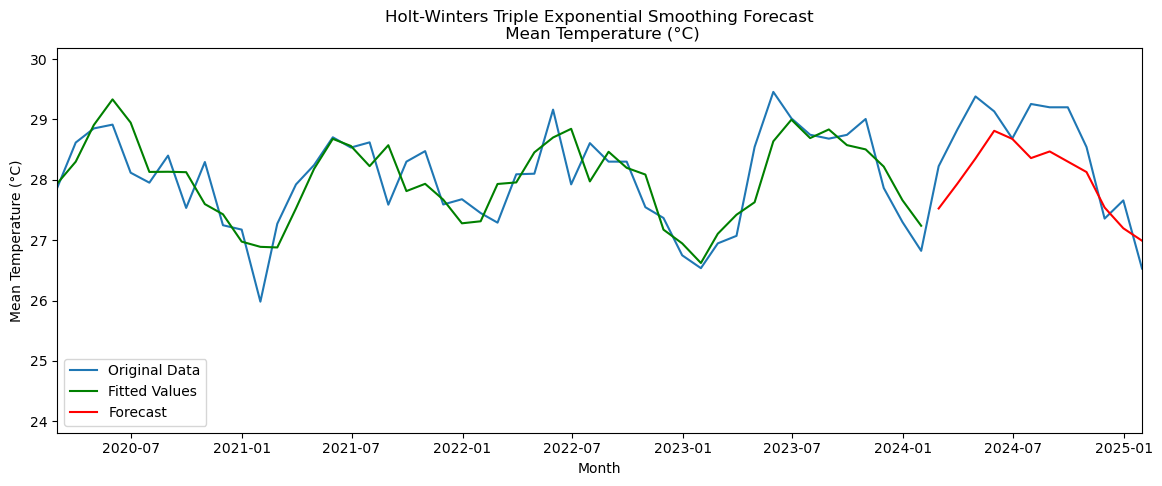

Mean Absolute Percentage Error of Mean Wind Speed (km/h) on testing data is 11.91%
Mean Root Squared Error of Mean Wind Speed (km/h) on testing data is 1.64
Mean Root Squared Error of Mean Wind Speed (km/h) on training data is 1.58


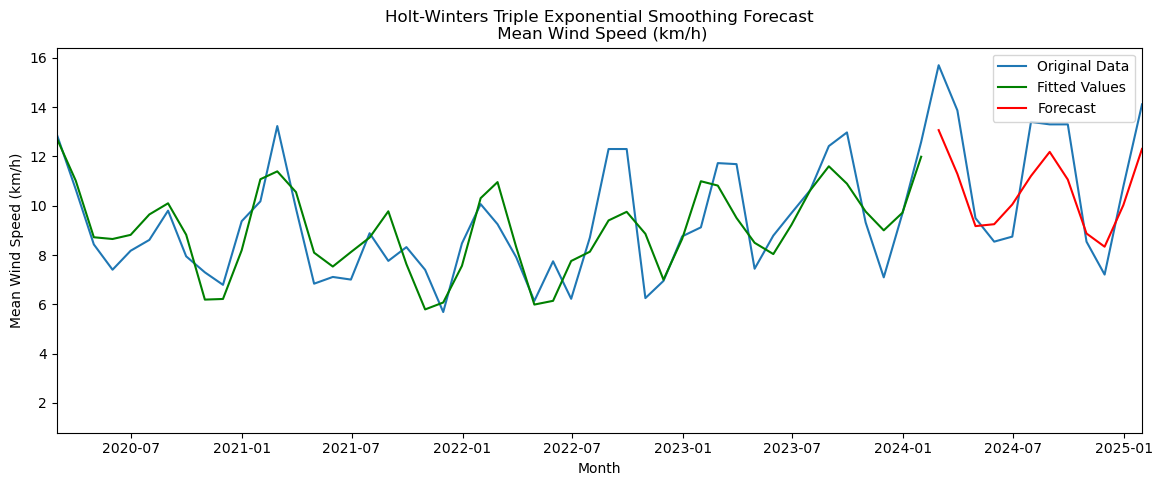

In [70]:
holtwinter_exponential(meanDf_ffill_Monthly, "Daily Rainfall Total (mm)", 12, 12)
holtwinter_exponential(meanDf_ffill_Monthly, "Mean Temperature (°C)", 12, 12)
holtwinter_exponential(meanDf_ffill_Monthly, "Mean Wind Speed (km/h)", 12, 12)

### Weekly

Mean Absolute Percentage Error of Daily Rainfall Total (mm) on testing data is 1068822139158057344.00%
Mean Root Squared Error of Daily Rainfall Total (mm) on testing data is 9.14
Mean Root Squared Error of Daily Rainfall Total (mm) on training data is 7.18


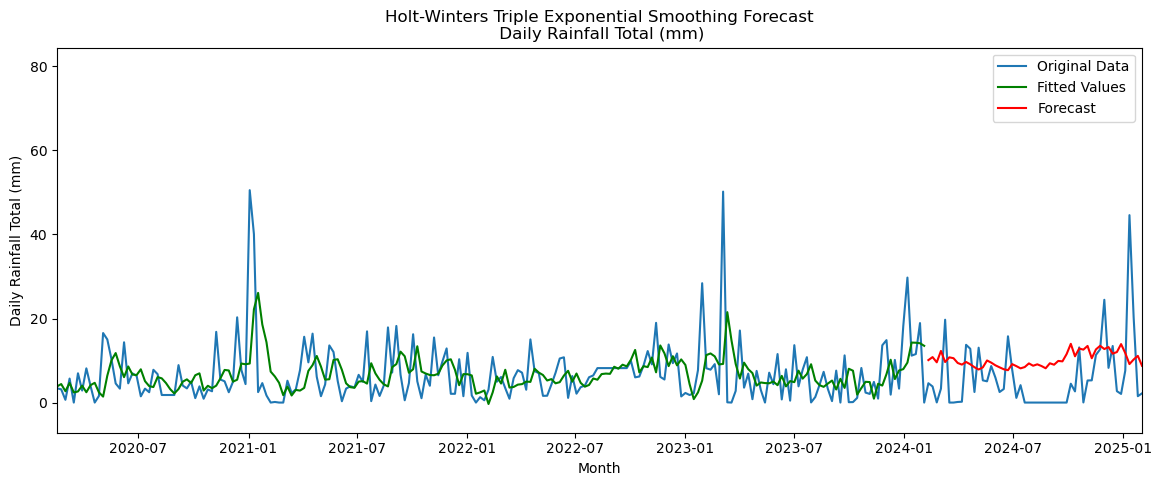

Mean Absolute Percentage Error of Mean Temperature (°C) on testing data is 2.75%
Mean Root Squared Error of Mean Temperature (°C) on testing data is 0.94
Mean Root Squared Error of Mean Temperature (°C) on training data is 0.62


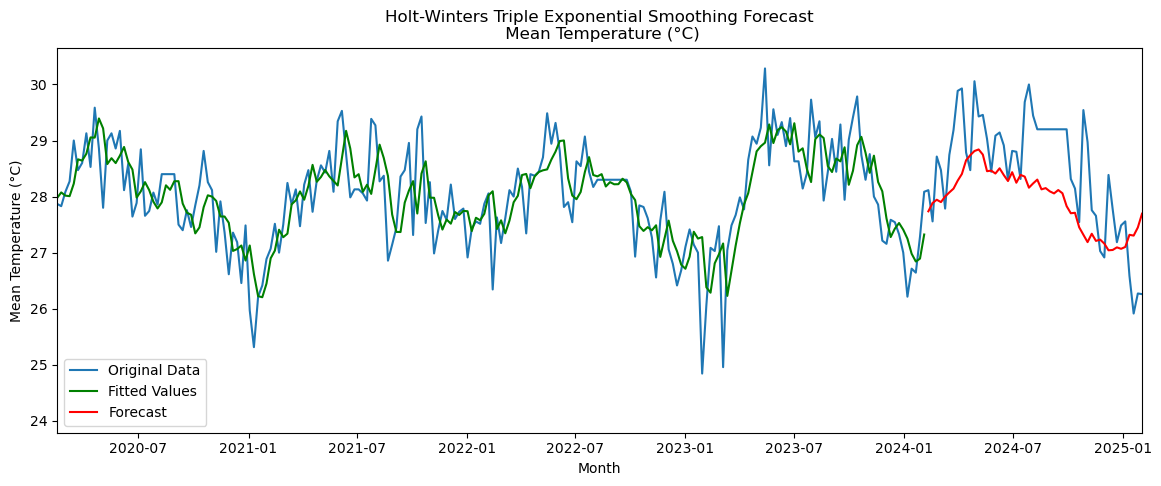

Mean Absolute Percentage Error of Mean Wind Speed (km/h) on testing data is 31.47%
Mean Root Squared Error of Mean Wind Speed (km/h) on testing data is 3.47
Mean Root Squared Error of Mean Wind Speed (km/h) on training data is 1.85


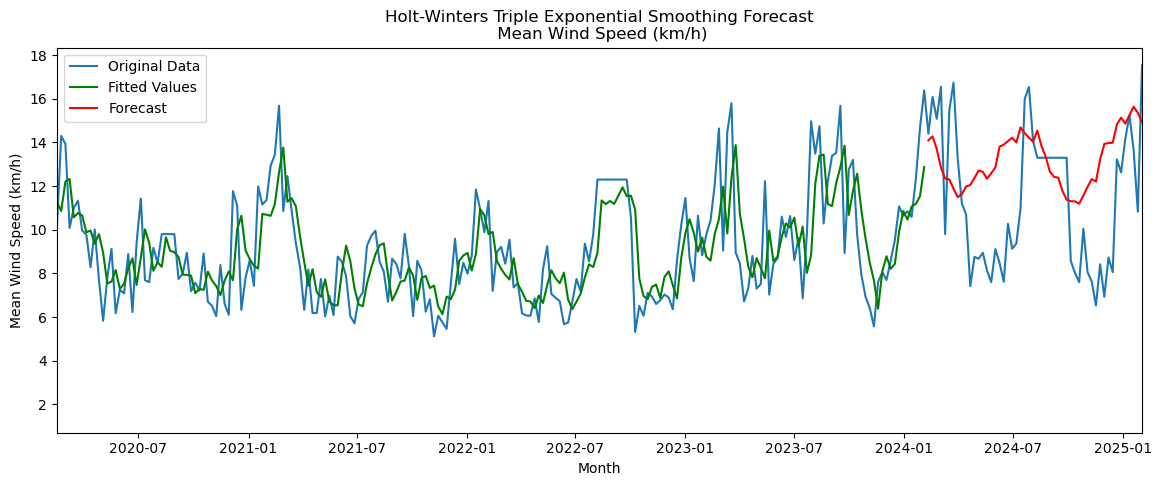

In [67]:
holtwinter_exponential(meanDf_ffill_Weekly, "Daily Rainfall Total (mm)", 52, 52)
holtwinter_exponential(meanDf_ffill_Weekly, "Mean Temperature (°C)", 52, 52)
holtwinter_exponential(meanDf_ffill_Weekly, "Mean Wind Speed (km/h)", 52, 52)

Mean Absolute Percentage Error of Daily Rainfall Total (mm) on testing data is 82.24%
Mean Root Squared Error of Daily Rainfall Total (mm) on testing data is 14.93
Mean Root Squared Error of Daily Rainfall Total (mm) on training data is 7.15


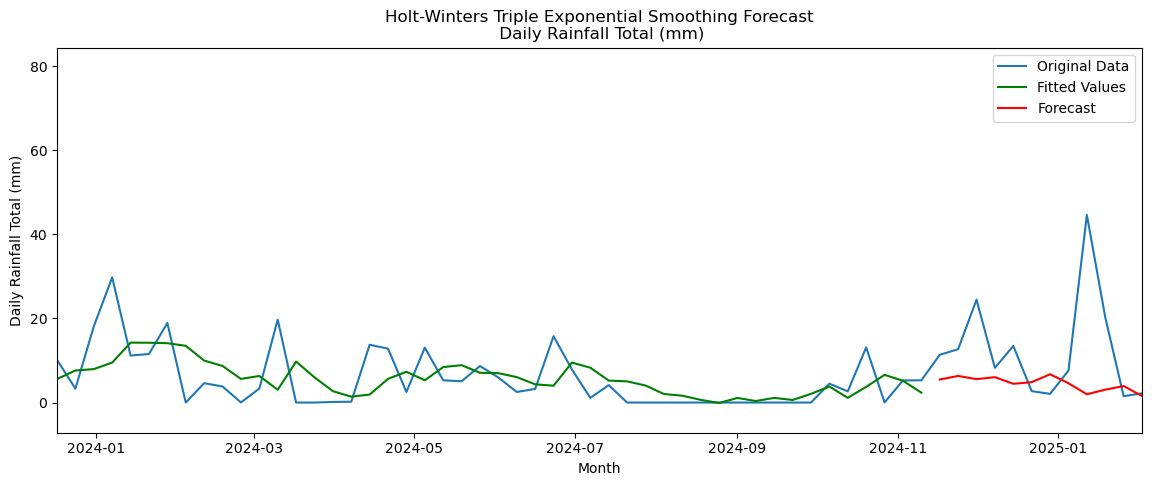

Mean Absolute Percentage Error of Mean Temperature (°C) on testing data is 4.50%
Mean Root Squared Error of Mean Temperature (°C) on testing data is 1.42
Mean Root Squared Error of Mean Temperature (°C) on training data is 0.62


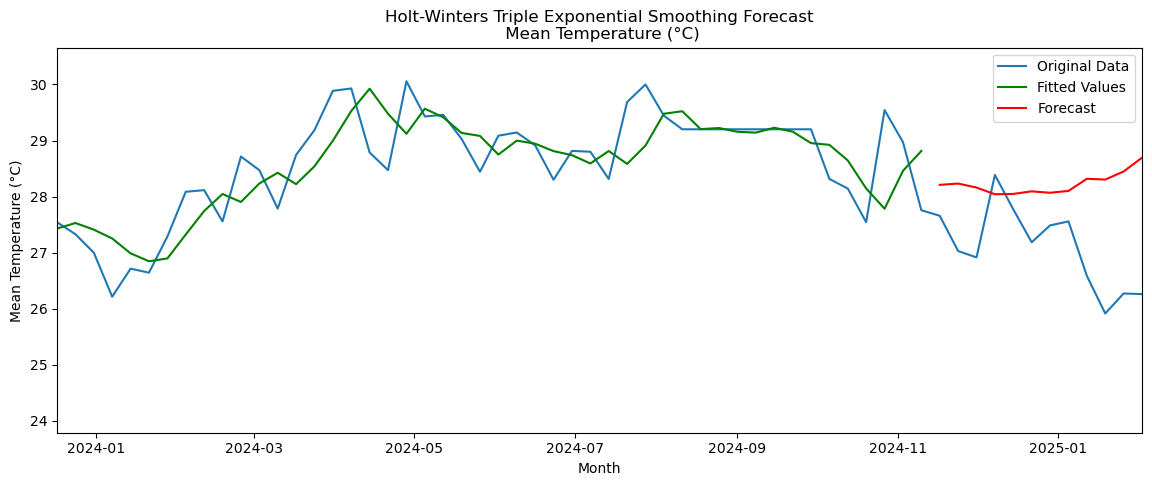

Mean Absolute Percentage Error of Mean Wind Speed (km/h) on testing data is 20.79%
Mean Root Squared Error of Mean Wind Speed (km/h) on testing data is 3.21
Mean Root Squared Error of Mean Wind Speed (km/h) on training data is 1.87


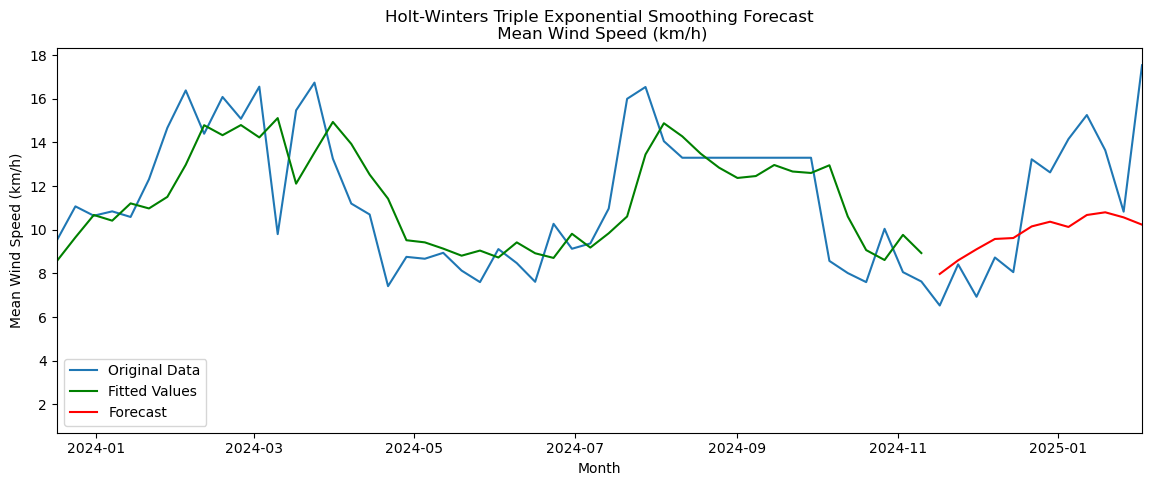

In [68]:
holtwinter_exponential(meanDf_ffill_Weekly, "Daily Rainfall Total (mm)", 52, 12)
holtwinter_exponential(meanDf_ffill_Weekly, "Mean Temperature (°C)", 52, 12)
holtwinter_exponential(meanDf_ffill_Weekly, "Mean Wind Speed (km/h)", 26, 12)

### Summary of Holt Winter Exponential Smoothing result
Mean Absolute Percent Error
|  |Rainfall | Temperature | Wind speed|
|--------------------------|----------------|-----------------|---------------|
| Monthly (12 month forecast) | Super high error | 2.03% | 11.91% |
| Weekly (51 week forecast) | Super high error | 2.75% | 31.47% |

Root Mean Square Error test (train)
|  |Rainfall | Temperature | Wind speed|
|--------------------------|----------------|-----------------|---------------|
| Monthly (12 month forecast) | 6.08 (6.48) | 0.66 (0.56)| 1.65 (1.58) |
| Weekly (51 week forecast) | 9.14 (7.18) | 0.94 (0.62) | 3.47 (1.85)|

## SARIMA

In [31]:
# set X the daily rainfall total
X = meanDf_ffill_Monthly['Daily Rainfall Total (mm)']

# Check stationarity of original data
adf_test(X, "Original Data Daily Rainfall Total (mm)")

# Apply differencing if needed
df_diff = X.diff().dropna()
adf_test(df_diff, "1st Differenced Data")  # Checking for d

# Seasonal differencing (D)
df_seasonal_diff = X.diff(12).dropna()
adf_test(df_seasonal_diff, "Seasonal Differenced Data (12)")  # Checking for D

# Seasonal + First Differencing
df_combined_diff = X.diff().diff(12).dropna()
adf_test(df_combined_diff, "1st + Seasonal Differenced Data (12)")

ADF Test for Original Data Daily Rainfall Total (mm):
  Test Statistic: -9.3832
  P-value: 0.0000
  Critical Values: {'1%': -3.443470002903981, '5%': -2.867326248740681, '10%': -2.569851849873108}
  Stationary

ADF Test for 1st Differenced Data:
  Test Statistic: -10.2525
  P-value: 0.0000
  Critical Values: {'1%': -3.4437386290417082, '5%': -2.867444458865948, '10%': -2.5699148492415413}
  Stationary

ADF Test for Seasonal Differenced Data (12):
  Test Statistic: -6.6164
  P-value: 0.0000
  Critical Values: {'1%': -3.444133731419755, '5%': -2.8676183066831036, '10%': -2.5700075029117166}
  Stationary

ADF Test for 1st + Seasonal Differenced Data (12):
  Test Statistic: -9.1813
  P-value: 0.0000
  Critical Values: {'1%': -3.444250937448703, '5%': -2.867669873870454, '10%': -2.5700349866579657}
  Stationary



In [32]:
# set X the daily rainfall total
X = meanDf_ffill_Monthly['Mean Temperature (°C)']

# Check stationarity of original data
adf_test(X, "Original Data Mean Temperature (°C)")

# Apply differencing if needed
df_diff = X.diff().dropna()
adf_test(df_diff, "1st Differenced Data")  # Checking for d

# Seasonal differencing (D)
df_seasonal_diff = X.diff(12).dropna()
adf_test(df_seasonal_diff, "Seasonal Differenced Data (12)")  # Checking for D

# Seasonal + First Differencing
df_combined_diff = X.diff().diff(12).dropna()
adf_test(df_combined_diff, "1st + Seasonal Differenced Data (12)")

ADF Test for Original Data Mean Temperature (°C):
  Test Statistic: -5.5130
  P-value: 0.0000
  Critical Values: {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}
  Stationary

ADF Test for 1st Differenced Data:
  Test Statistic: -10.1246
  P-value: 0.0000
  Critical Values: {'1%': -3.4437112724287253, '5%': -2.8674324209387345, '10%': -2.569908433637385}
  Stationary

ADF Test for Seasonal Differenced Data (12):
  Test Statistic: -8.0008
  P-value: 0.0000
  Critical Values: {'1%': -3.4440471158221206, '5%': -2.867580197120949, '10%': -2.5699871918402777}
  Stationary

ADF Test for 1st + Seasonal Differenced Data (12):
  Test Statistic: -9.5497
  P-value: 0.0000
  Critical Values: {'1%': -3.4441920863262863, '5%': -2.8676439813617147, '10%': -2.570021186703601}
  Stationary



In [33]:

X = meanDf_ffill_Monthly['Mean Wind Speed (km/h)']

# Check stationarity of original data
adf_test(X, "Original Data Mean Wind Speed (km/h)")

# Apply differencing if needed
df_diff = X.diff().dropna()
adf_test(df_diff, "1st Differenced Data")  # Checking for d

# Seasonal differencing (D)
df_seasonal_diff = X.diff(6).dropna()
adf_test(df_seasonal_diff, "Seasonal Differenced Data (6)")  # Checking for D

# Seasonal + First Differencing
df_combined_diff = X.diff().diff(6).dropna()
adf_test(df_combined_diff, "1st + Seasonal Differenced Data (6)")

ADF Test for Original Data Mean Wind Speed (km/h):
  Test Statistic: -2.2754
  P-value: 0.1800
  Critical Values: {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
  Not Stationary

ADF Test for 1st Differenced Data:
  Test Statistic: -8.5537
  P-value: 0.0000
  Critical Values: {'1%': -3.4438213751870337, '5%': -2.867480869596464, '10%': -2.5699342544006987}
  Stationary

ADF Test for Seasonal Differenced Data (6):
  Test Statistic: -5.5620
  P-value: 0.0000
  Critical Values: {'1%': -3.4440471158221206, '5%': -2.867580197120949, '10%': -2.5699871918402777}
  Stationary

ADF Test for 1st + Seasonal Differenced Data (6):
  Test Statistic: -10.1850
  P-value: 0.0000
  Critical Values: {'1%': -3.44407586647939, '5%': -2.867592847097137, '10%': -2.5699939338217668}
  Stationary



The Daily Rainfall Total (mm), Mean Temperature (°C), Mean Wind Speed (km/h) - 1st Diff are stationary

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(data, column, lags=32,):
    plot_data = data[column]
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plot_acf(plot_data.dropna(), lags=lags, ax=axes[0])
    plot_pacf(plot_data.dropna(), lags=lags, ax=axes[1])
    axes[0].set_title(f'Autocorrelation Function (ACF) of {column}')
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) of {column}')
    plt.show()


In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

params = (1, 0, 1, 1, 1, 1, 12)

def sarima_plot(data, column, forecast_period, params, title ):
  p,d,q, P, D, Q, S = params
  train_data = data[column][:-forecast_period]  # Training data
  test_data = data[column][-forecast_period:]  # Testing data

  sarima_model = SARIMAX(train_data, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()

  # Get the forecast/pred
  pred = sarima_model.get_prediction(start='2024-02-29', end='2025-01-31').predicted_mean

  mape_test = mean_absolute_percentage_error(test_data, pred)
  print(f'Model Mean Absolute Percentage Error on testing data is {mape_test*100:.2f}%')
  rmse_test = root_mean_squared_error(test_data, pred)
  print(f'Model Root Mean Squared Error on testing data is {rmse_test:.2f}')
  rmse_train = root_mean_squared_error(train_data, sarima_model.fittedvalues)
  print(f'Model Root Mean Squared Error on training data is {rmse_train:.2f}')

  # pred = sarima_model.get_prediction(start=0, end=12).predicted_mean
  fig, ax = plt.subplots(figsize=(14, 5))
  ax.plot(train_data, label='training')
  ax.plot(test_data, label='testing')
  ax.plot(pred, label='prediction')
  plt.legend()
  plt.title(title)
  plt.xlim([train_data.index[-12*5], pred.index.max()])
  plt.show()

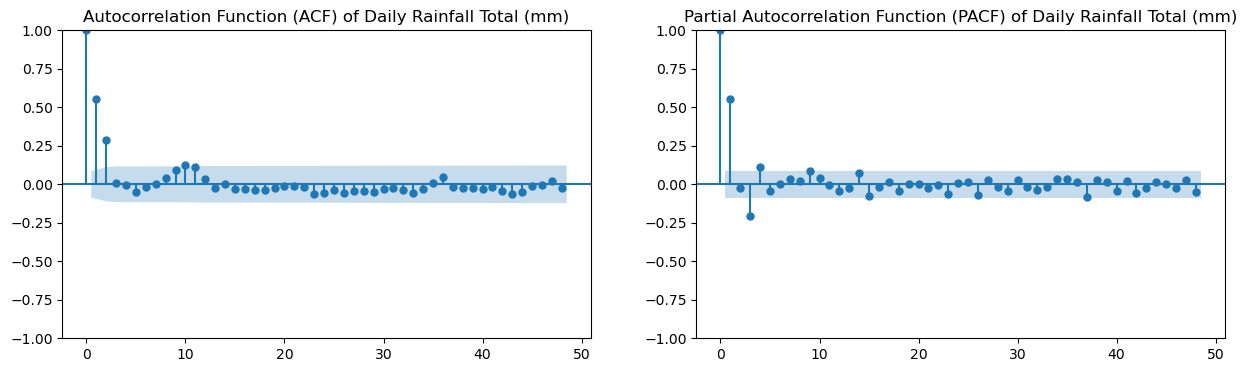

In [56]:
plot_acf_pacf(meanDf_ffill_Monthly, 'Daily Rainfall Total (mm)', lags=48)


In [57]:
prams = [(1, 0, 2, 0, 0, 0, 12), 
         (1, 0, 2, 0, 0, 1, 12),
         (1, 0, 2, 1, 0, 0, 12),
         (1, 0, 2, 1, 0, 1, 12),
         (1, 0, 2, 1, 1, 1, 12),
         (1, 0, 2, 0, 1, 0, 12), 
         (1, 0, 2, 0, 1, 1, 12),
         (1, 0, 2, 1, 1, 0, 12),
         (1, 0, 2, 1, 1, 1, 12)
         ]

train_data = meanDf_ffill_Monthly['Daily Rainfall Total (mm)'][:-12]
for p, d, q, P, D, Q, S in prams:
  sarima_model = SARIMAX(train_data, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
  print(f"Model: {p, d, q, P, D, Q, S} | BIC: {sarima_model.bic} | AIC: {sarima_model.aic}")


Model: (1, 0, 2, 0, 0, 0, 12) | BIC: 3237.721142136903 | AIC: 3220.919105440732
Model: (1, 0, 2, 0, 0, 1, 12) | BIC: 3242.639068166461 | AIC: 3221.6365222962477
Model: (1, 0, 2, 1, 0, 0, 12) | BIC: 3242.4765294189715 | AIC: 3221.473983548758
Model: (1, 0, 2, 1, 0, 1, 12) | BIC: 3193.52821812296 | AIC: 3168.325163078704
Model: (1, 0, 2, 1, 1, 1, 12) | BIC: 3130.329410503806 | AIC: 3105.2742068831712
Model: (1, 0, 2, 0, 1, 0, 12) | BIC: 3429.9801092057637 | AIC: 3413.2766401253407
Model: (1, 0, 2, 0, 1, 1, 12) | BIC: 3124.731238152622 | AIC: 3103.8519018020934
Model: (1, 0, 2, 1, 1, 0, 12) | BIC: 3310.587237560227 | AIC: 3289.7079012096983
Model: (1, 0, 2, 1, 1, 1, 12) | BIC: 3130.329410503806 | AIC: 3105.2742068831712


Model Mean Absolute Percentage Error on testing data is 340729352193134080.00%
Model Root Mean Squared Error on testing data is 4.28
Model Root Mean Squared Error on training data is 5.95


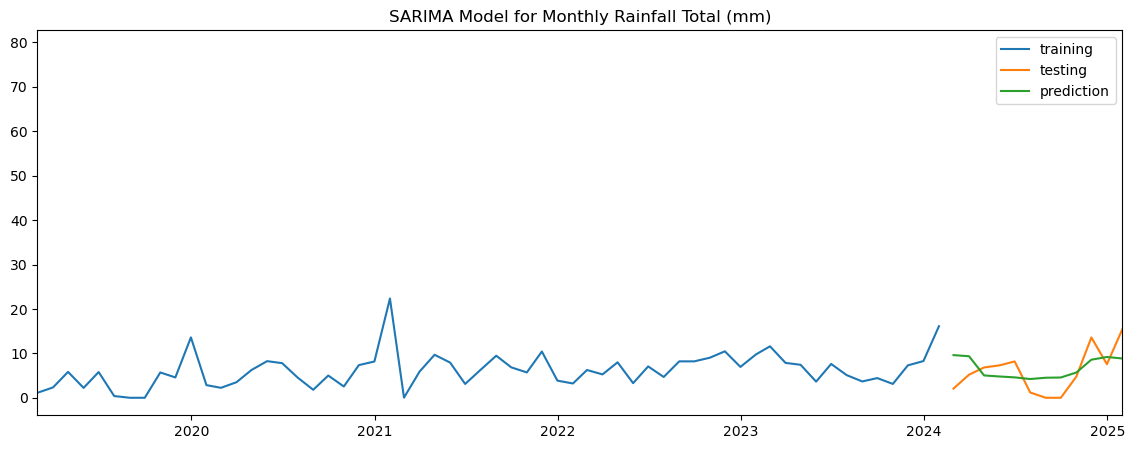

In [58]:
params = (1, 0, 2, 0, 1, 1, 12)
sarima_plot(meanDf_ffill_Monthly, 'Daily Rainfall Total (mm)', 12, params, title="SARIMA Model for Monthly Rainfall Total (mm)")

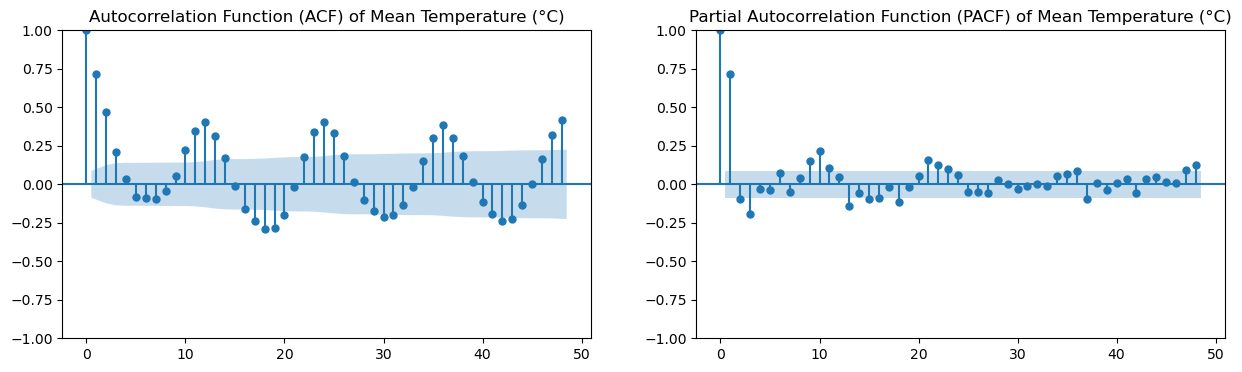

In [59]:
plot_acf_pacf(meanDf_ffill_Monthly, 'Mean Temperature (°C)', lags=48)

In [60]:
prams = [(1, 0, 3, 0, 0, 0, 12),
         (1, 0, 3, 0, 0, 1, 12),
         (1, 0, 3, 1, 0, 0, 12),
        #  (1, 0, 3, 1, 0, 1, 12),
         (1, 0, 3, 1, 1, 1, 12),
         (1, 0, 3, 0, 1, 0, 12),
         (1, 0, 3, 0, 1, 1, 12),
         (1, 0, 3, 1, 1, 0, 12),
         ]

train_data = meanDf_ffill_Monthly['Mean Temperature (°C)'][:-12]
for p, d, q, P, D, Q, S in prams:
  sarima_model = SARIMAX(train_data, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()
  print(f"Model: {p, d, q, P, D, Q, S} | BIC: {sarima_model.bic} | AIC: {sarima_model.aic}")

Model: (1, 0, 3, 0, 0, 0, 12) | BIC: 1012.770640814881 | AIC: 991.7680949446675
Model: (1, 0, 3, 0, 0, 1, 12) | BIC: 993.1782993170125 | AIC: 967.9752442727563
Model: (1, 0, 3, 1, 0, 0, 12) | BIC: 1295.9358961352127 | AIC: 1270.7328410909565
Model: (1, 0, 3, 1, 1, 1, 12) | BIC: 854.4356820144567 | AIC: 825.2046111237164
Model: (1, 0, 3, 0, 1, 0, 12) | BIC: 1119.8596827339993 | AIC: 1098.9803463834705
Model: (1, 0, 3, 0, 1, 1, 12) | BIC: 848.6353173294726 | AIC: 823.5801137088381
Model: (1, 0, 3, 1, 1, 0, 12) | BIC: 993.0566055856274 | AIC: 968.0014019649929


Model Mean Absolute Percentage Error on testing data is 2.29%
Model Root Mean Squared Error on testing data is 0.74
Model Root Mean Squared Error on training data is 4.35


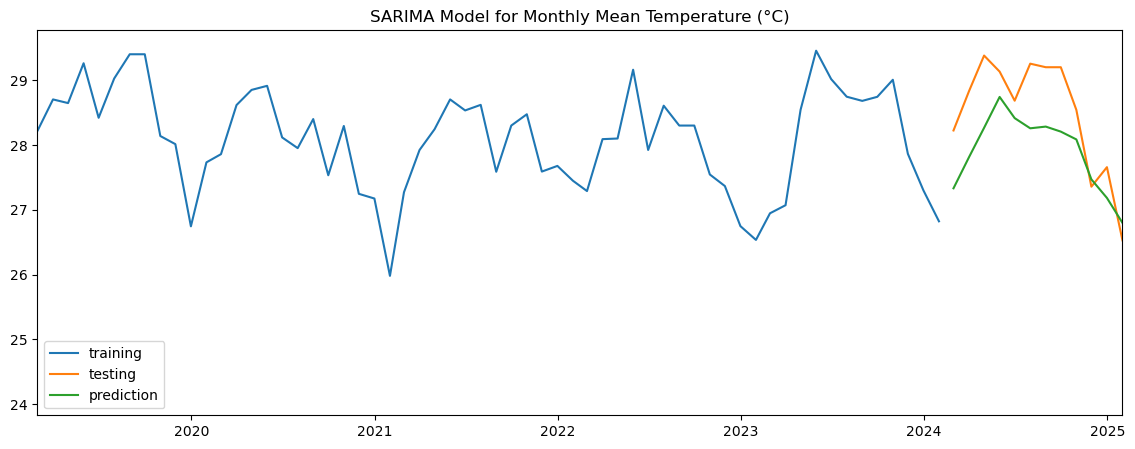

In [61]:
params = (1, 0, 3, 0, 1, 1, 12)
sarima_plot(meanDf_ffill_Monthly, 'Mean Temperature (°C)', 12, params=params, title="SARIMA Model for Monthly Mean Temperature (°C)")

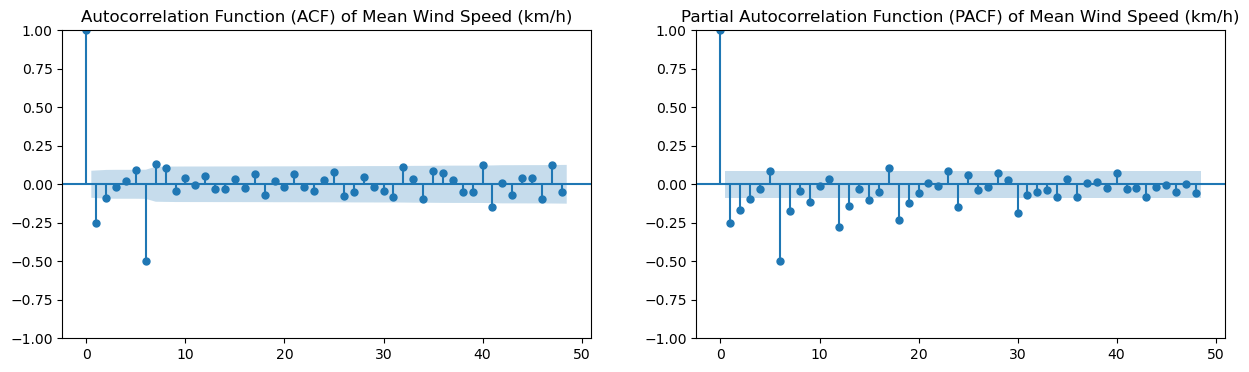

In [62]:
plot_acf_pacf(meanDf_ffill_Monthly.diff().diff(6).dropna(), 'Mean Wind Speed (km/h)', lags=48)

In [63]:
params = [
    (2, 1, 1, 0, 0, 1, 6),
    (2, 1, 1, 0, 1, 1, 6),
    (2, 1, 1, 1, 1, 1, 6),
    # (2, 1, 1, 1, 0, 1, 6),
    # (2, 1, 1, 1, 0, 0, 6)
         ]

train_data = meanDf_ffill_Monthly['Mean Wind Speed (km/h)'][:-12]
for p, d, q, P, D, Q, S in params:
    sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, S)).fit()
    print(f"Model: {p, d, q, P, D, Q, S} | BIC: {sarima_model.bic} | AIC: {sarima_model.aic}")

/Users/sohengkhiong/anaconda3/envs/singaporePoly/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/sohengkhiong/anaconda3/envs/singaporePoly/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Model: (2, 1, 1, 0, 0, 1, 6) | BIC: 2015.7668461943038 | AIC: 1994.7744526118422
Model: (2, 1, 1, 0, 1, 1, 6) | BIC: 1868.9521180104969 | AIC: 1848.0210748909944
Model: (2, 1, 1, 1, 1, 1, 6) | BIC: 1874.149967202373 | AIC: 1849.0327154589702


Model Mean Absolute Percentage Error on testing data is 13.05%
Model Root Mean Squared Error on testing data is 1.98
Model Root Mean Squared Error on training data is 1.72


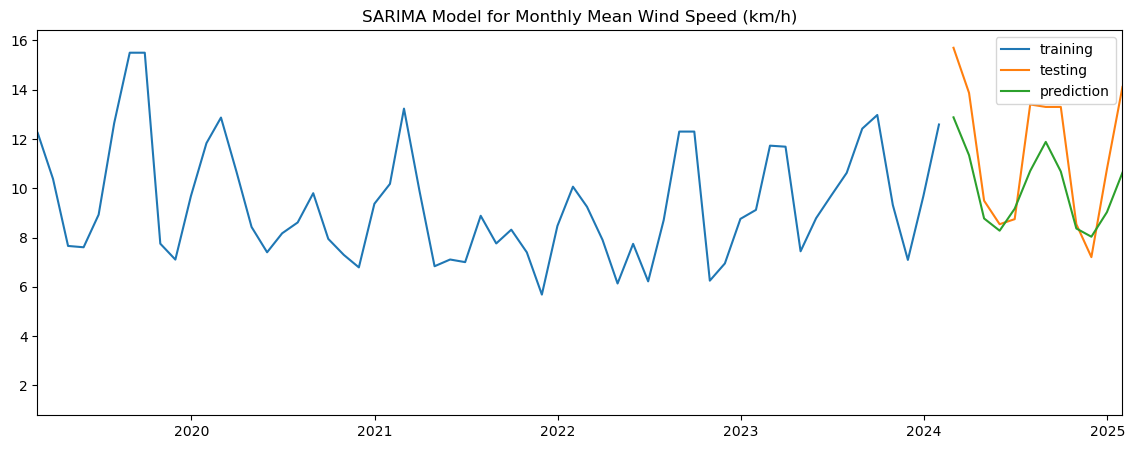

In [64]:
params = (2, 1, 1, 0, 1, 1, 6)
sarima_plot(meanDf_ffill_Monthly, 'Mean Wind Speed (km/h)', 12, params=params, title="SARIMA Model for Monthly Mean Wind Speed (km/h)")

### Summary of SARIMA result
Mean Absolute Percent Error
|  |Rainfall | Temperature | Wind speed|
|--------------------------|----------------|-----------------|---------------|
| Monthly (12 month forecast) | Super high error | 2.29% | 13.05% |

Root Mean Square Error test (train)
|  |Rainfall | Temperature | Wind speed|
|--------------------------|----------------|-----------------|---------------|
| Monthly (12 month forecast) | 4.28 (5.95) | 0.74 (4.35)| 1.98(1.72) |


# Conclusion
The weather is getting wetter, hotter and Windier as shown in the trend in Prophet composition plot

In the forecasting model:
Rain mean absolute error is high at 61.55% but it is the best among the 3 model
Temperature mean absolute error is 1.56% in Prophet
Wind mean absolute error is 11.91% in Holt Winter Exponential smoothing